# 📊 Исследование статистических данных
## Анализ данных из файла `Nauka_4.xlsx`, включая:
- Описание данных
- Гистограммы и графики распределения
- Расчёт числовых характеристик
- Проверку гипотезы о нормальности
- Доверительные интервалы

## Импорт и установка библиотек

In [108]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.nonparametric.kde import KDEUnivariate
from IPython.display import display
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.float_format', lambda x: f'{x:,.3f}')
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['axes.grid'] = True


## Загрузка данных
Загрузите ваш файл `Nauka_4.xlsx` или `Nauka_4.csv` через панель файлов Google Colab (слева) и укажите путь ниже.

In [109]:
# Копия исходных данных
df_clean = df.copy()

# Убираем строки, где нет числовых данных (служебные и примечания)
mask = df_clean.iloc[:, 1:].notna().any(axis=1)
df_clean = df_clean[mask]

# Фильтруем только нужные строки (исключаем "в том числе", "в процентах" и примечания)
df_clean = df_clean[~df_clean["Показатель"].str.contains("в том числе|в процентах|1\\)|2\\)", case=False, regex=True)]

# Чистим названия годов (убираем запятые, точки, нули и приводим к int)
df_clean.columns = [df_clean.columns[0]] + [int(str(c).replace(',', '').replace('.', '').strip()) for c in df_clean.columns[1:]]

# Преобразуем числовые значения в float
for col in df_clean.columns[1:]:
    df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

corrected_columns = [df_clean.columns[0]]

for c in df_clean.columns[1:]:
    c_str = str(c)
    if len(c_str) == 5 and c_str.endswith("0"):
        corrected_columns.append(int(c_str[:-1]))
    else:
        corrected_columns.append(int(c_str))

df_clean.columns = corrected_columns
df_clean = df_clean.reset_index(drop=True)

display(df_clean)


,Показатель,2000,2005,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
0,Расходы на гражданскую науку из \nсредств фед...,"17,396.400","76,909.300","237,644.000","313,899.300","355,921.100","425,301.700","437,273.300","439,392.800","402,722.300","377,882.200","420,472.300",NaN,"549,602.200","626,574.300","631,701.600","691,758.900","716,858.000"
1,на фундаментальные исследования,"8,219.300","32,025.100","82,172.000","91,684.500","86,623.200","112,230.900","121,599.500","120,203.800","105,247.600","116,977.600","149,550.000","192,495.000","203,246.800","225,152.700","247,286.900","244,313.400","268,115.100"
2,на прикладные научные исследования,"9,177.100","44,884.200","155,472.000","222,214.800","269,297.900","313,070.800","315,673.800","319,188.900","297,474.700","260,904.600","270,922.300","296,663.100","346,355.400","401,421.600","384,414.800","447,445.500","448,742.900"
3,к расходам федерального бюджета,1.690,2.190,2.350,2.870,2.760,3.190,2.950,2.810,2.450,2.300,2.520,2.690,2.410,2.530,2.510,2.760,2.380


## Определение основной числовой переменной

In [110]:
num_col = None
for c in df.columns:
    if pd.api.types.is_numeric_dtype(df[c]):
        num_col = c
        break
if num_col is None:
    raise ValueError("❌ Не найден числовой столбец.")
print(f"Используется переменная: {num_col}")

data = df[num_col].dropna().astype(float)
n = len(data)


Используется переменная: 2000.0


## Основные числовые характеристики данных

In [111]:
mean = data.mean()
median = data.median()
var = data.var(ddof=1)
std = data.std(ddof=1)
q1, q3 = data.quantile([0.25, 0.75])
iqr = q3 - q1
skew = data.skew()
kurt = data.kurtosis()

summary = pd.DataFrame({
    "Число наблюдений n": [n],
    "Среднее": [mean],
    "Медиана": [median],
    "Дисперсия": [var],
    "Ст. отклонение": [std],
    "Q1": [q1],
    "Q3": [q3],
    "IQR": [iqr],
    "Асимметрия": [skew],
    "Эксцесс": [kurt]
})
display(summary)


,Число наблюдений n,Среднее,Медиана,Дисперсия,Ст. отклонение,Q1,Q3,IQR,Асимметрия,Эксцесс
0,5,"6,958.946","8,219.300","53,069,036.405","7,284.850",1.690,"9,177.100","9,175.410",0.513,-0.640


## Гистограмма распределения

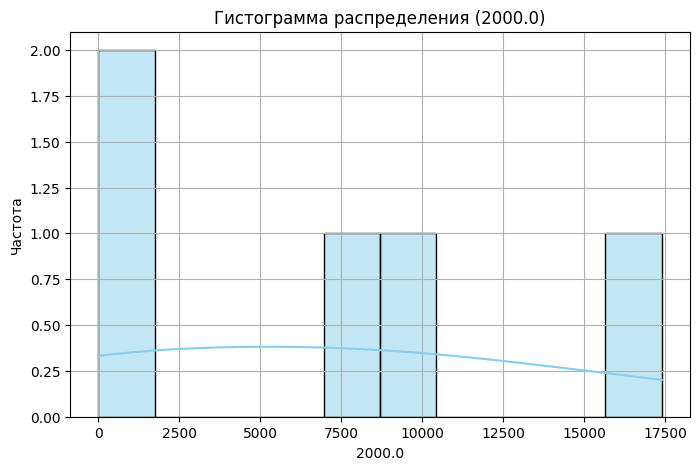

In [112]:
plt.figure(figsize=(8,5))
sns.histplot(data, bins=10, kde=True, color='skyblue')
plt.title(f"Гистограмма распределения ({num_col})")
plt.xlabel(num_col)
plt.ylabel("Частота")
plt.show()


## Проверка гипотезы о нормальности (Шапиро, Колмогоров-Смирнов)

In [113]:
sh_stat, sh_p = stats.shapiro(data)
ks_stat, ks_p = stats.kstest((data - data.mean())/data.std(), 'norm')

print("Тест Шапиро–Уилка: p-value =", round(sh_p,4))
print("Тест Колмогорова–Смирнова: p-value =", round(ks_p,4))

if sh_p > 0.05:
    print("Вывод: Распределение близко к нормальному.")
else:
    print("Вывод: Распределение отличается от нормального.")


Тест Шапиро–Уилка: p-value = 0.3782
Тест Колмогорова–Смирнова: p-value = 0.9003
Вывод: Распределение близко к нормальному.


## Доверительный интервал для среднего значения (95%)

In [114]:
alpha = 0.05
t_crit = stats.t.ppf(1 - alpha/2, df=n-1)
se = std / np.sqrt(n)
ci_low = mean - t_crit * se
ci_high = mean + t_crit * se
print(f"95% доверительный интервал для среднего: [{ci_low:.3f}; {ci_high:.3f}]")


95% доверительный интервал для среднего: [-2086.390; 16004.282]


## Поиск выбросов по правилу 1.5 * IQR

In [115]:
lower = q1 - 1.5 * iqr
upper = q3 + 1.5 * iqr
outliers = data[(data < lower) | (data > upper)]
print(f"Количество выбросов: {len(outliers)}")
if len(outliers) > 0:
    display(outliers.describe())


Количество выбросов: 0


## Сравнение между показателями

                                          Показатель   Год   Значение
0  Расходы  на гражданскую науку из \nсредств фед...  2000 17,396.400
1                    на фундаментальные исследования  2000  8,219.300
2                 на прикладные научные исследования  2000  9,177.100
3                    к расходам федерального бюджета  2000      1.690
4  Расходы  на гражданскую науку из \nсредств фед...  2005 76,909.300


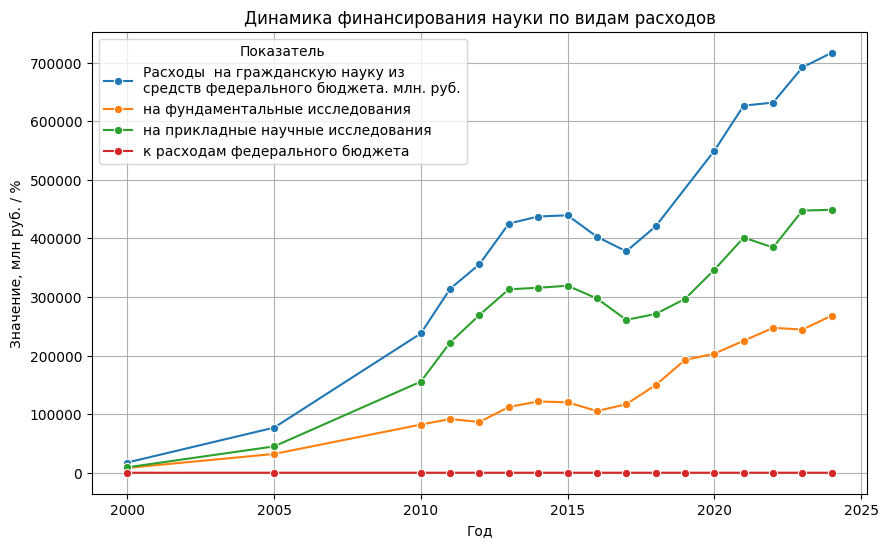

In [116]:
df_long = df_clean.melt(id_vars="Показатель", var_name="Год", value_name="Значение")

print(df_long.head())

plt.figure(figsize=(10,6))
sns.lineplot(data=df_long, x="Год", y="Значение", hue="Показатель", marker="o")
plt.title("Динамика финансирования науки по видам расходов")
plt.ylabel("Значение, млн руб. / %")
plt.xlabel("Год")
plt.grid(True)
plt.show()

## 🔟 Итоговые выводы

In [117]:
print(f"""Основные результаты:
1. Среднее значение: {mean:.3f}
2. Медиана: {median:.3f}
3. Асимметрия: {skew:.3f}
4. Проверка нормальности: p(Шапиро) = {sh_p:.4f}
5. 95% доверительный интервал: [{ci_low:.3f}; {ci_high:.3f}]
6. Количество выбросов: {len(outliers)}
""")

Основные результаты:
1. Среднее значение: 6958.946
2. Медиана: 8219.300
3. Асимметрия: 0.513
4. Проверка нормальности: p(Шапиро) = 0.3782
5. 95% доверительный интервал: [-2086.390; 16004.282]
6. Количество выбросов: 0

